<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/analyze_results_of_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [ ]:
## import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep
# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
# others
import json
from collections import OrderedDict
import pprint
import re
from IPython.display import clear_output
import math


#Historyデータの用意

In [17]:
## gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

## colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")

Already confirm
Created at /content/desk


## データを選択（ノイズから選ぶ）

In [18]:
path_Histories = "/content/drive/MyDrive/colab/CM_experiment/histories"
all_history_directories = os.listdir(path_Histories)
all_history_directories = sorted(all_history_directories)
print("Pick up one key from the below directories")
for key, each_noize_histories in enumerate(all_history_directories):
  print(each_noize_histories, "key:", key)

pick_key = int(input())

clear_output()
print("The key is", pick_key, "and", all_history_directories[pick_key])

The key is 0 and noize=0.0


In [55]:
path_pickup_histories = path.join(path_Histories, all_history_directories[pick_key])

each_loss_pattern = r"KTH\.(\d+\.)+\w+"

used_losses = []

if path.isdir(path_pickup_histories):
  print("expand", path_pickup_histories)
  partial_histories = os.listdir(path_pickup_histories)
  partial_histories = sorted(partial_histories)

  count_each = 0
  each_loss_header_old = ""
  some_histories = []
  each_loss_histories = []

  for i, each_history in enumerate(partial_histories):
    each_loss_header = re.match(each_loss_pattern, each_history).group()
    each_loss_header = re.sub(r"KTH(\.\d+)+\.", '', each_loss_header)

    if each_loss_header != each_loss_header_old and each_loss_header_old != "": # change different loss
      # update for the next loss
      some_histories.append(each_loss_histories)
      used_losses.append(each_loss_header_old)

      count_each = 0
      each_loss_histories = []
      print("------------------------------------------------------------------------------")

    else:
      pass
    
    the_history = pd.read_csv(path.join(path_pickup_histories, each_history))
    each_loss_histories.append(the_history)
      

    print(each_loss_header, "-", count_each+1, "@", i+1)
    count_each += 1
    each_loss_header_old = each_loss_header

    if (i+1) == len(partial_histories): # when the last element
      some_histories.append(each_loss_histories)
      used_losses.append(each_loss_header)
    else:
      pass


expand /content/drive/MyDrive/colab/CM_experiment/histories/noize=0.0
CategoricalCrossentropy - 1 @ 1
CategoricalCrossentropy - 2 @ 2
CategoricalCrossentropy - 3 @ 3
CategoricalCrossentropy - 4 @ 4
CategoricalCrossentropy - 5 @ 5
CategoricalCrossentropy - 6 @ 6
------------------------------------------------------------------------------
MeanAbsoluteError - 1 @ 7
MeanAbsoluteError - 2 @ 8
MeanAbsoluteError - 3 @ 9
MeanAbsoluteError - 4 @ 10
MeanAbsoluteError - 5 @ 11
MeanAbsoluteError - 6 @ 12
------------------------------------------------------------------------------
MeanSquaredError - 1 @ 13
MeanSquaredError - 2 @ 14
MeanSquaredError - 3 @ 15
MeanSquaredError - 4 @ 16
MeanSquaredError - 5 @ 17
MeanSquaredError - 6 @ 18


In [56]:
print("used in the experiment as loss function :")
print(used_losses)

used in the experiment as loss function :
['CategoricalCrossentropy', 'MeanAbsoluteError', 'MeanSquaredError']


# 選んだノイズに関する実験のすべてのlossとaccを可視化

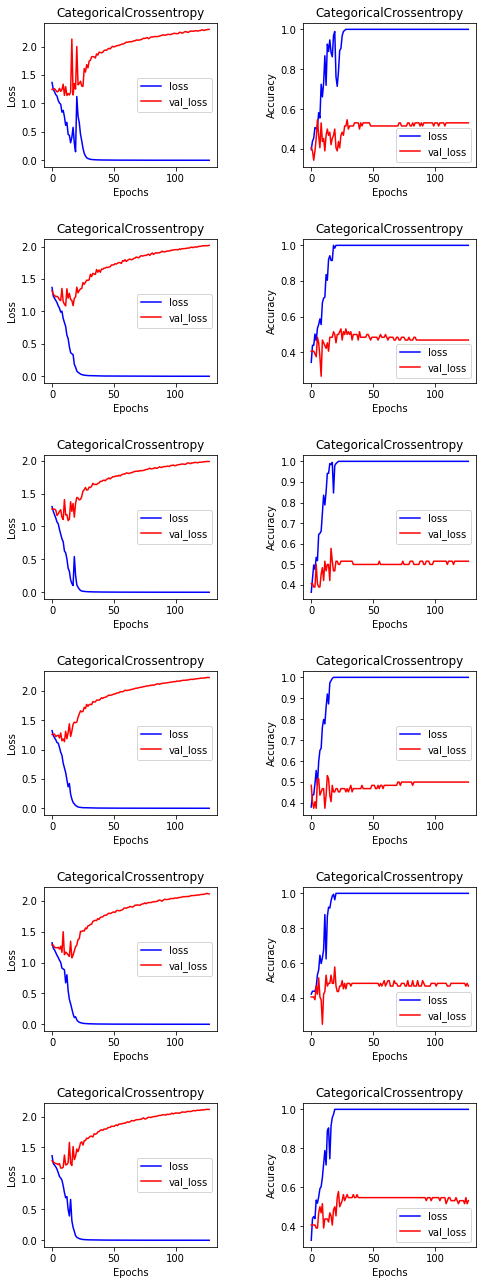

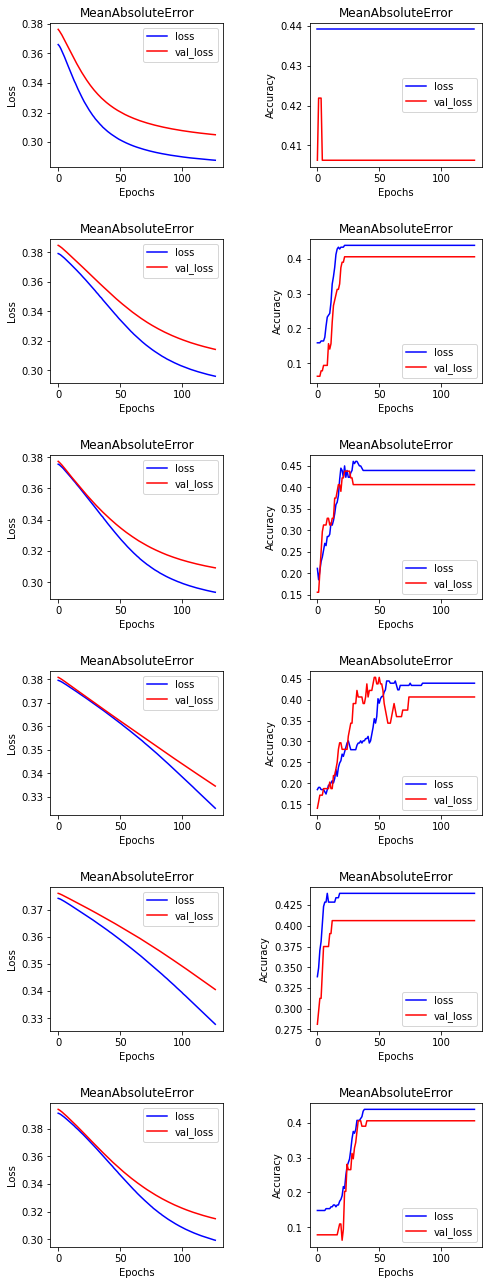

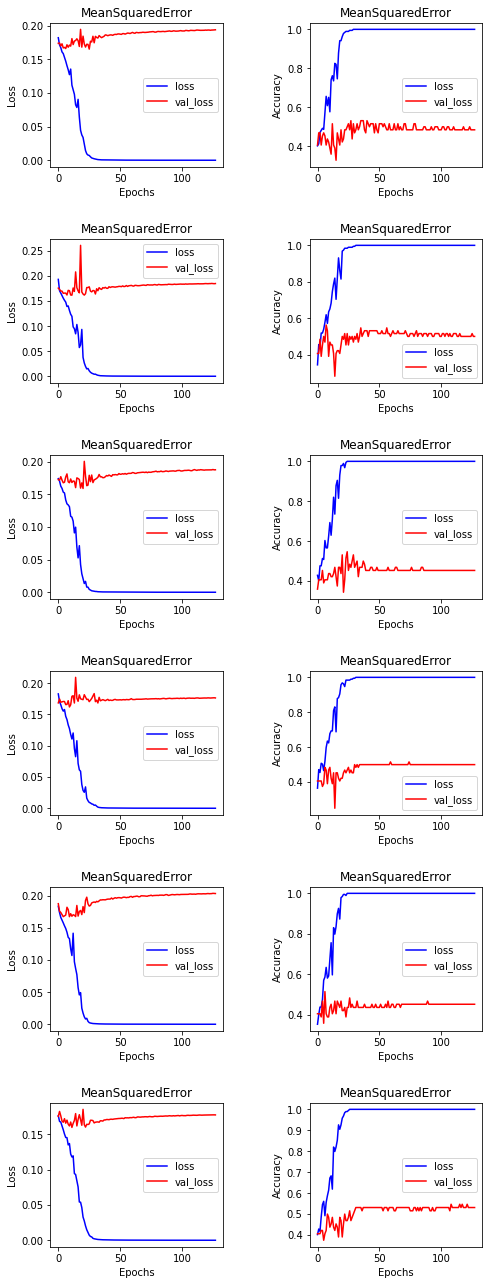

In [57]:
noize_rate = all_history_directories[pick_key]
noize_rate = str(noize_rate)

WIDTH = 8
HEIGHT = 10

for key_loss, each_loss in enumerate(used_losses):
  # 図のインスタンス作成
  fig = plt.figure(figsize=(WIDTH, HEIGHT))

  ## 図にグラフをプロット
  k = 1
  rate = 1.5  # プロットのための係数
  for row in range(6):
    # LOSS part
    ## set
    LOSS_plt = fig.add_subplot(6, 2, k)
    LOSS_plt.set_position([0.3*1*rate, 0.2*row*rate, 0.3, 0.2])
    LOSS_plt.set_title(each_loss)
    LOSS_plt.set_xlabel('Epochs')
    LOSS_plt.set_ylabel('Loss')
    ## plot 
    loss = some_histories[key_loss][row]["loss"] 
    val_loss = some_histories[key_loss][row]["val_loss"]
    LOSS_plt.plot(loss, label='loss', color='blue') # plot loss
    LOSS_plt.plot(val_loss, label='val_loss', color='red') # plot val_loss
    LOSS_plt.legend(loc='best')

    k+=1

    # ACC part
    ## set
    ACC_plt = fig.add_subplot(6, 2, k)
    ACC_plt.set_position([0.3*2*rate, 0.2*row*rate, 0.3, 0.2])
    ACC_plt.set_title(each_loss)
    ACC_plt.set_xlabel('Epochs')
    ACC_plt.set_ylabel('Accuracy')
    ## plot 
    acc = some_histories[key_loss][row]["acc"] 
    val_acc = some_histories[key_loss][row]["val_acc"]
    ACC_plt.plot(acc, label='loss', color='blue') # plot acc
    ACC_plt.plot(val_acc, label='val_loss', color='red') # plot val_loss
    ACC_plt.legend(loc='best')
    k += 1
  
  filename = noize_rate + each_loss + "_six" + ".png"
  save_path = path.join(desk, filename)
  fig.savefig(save_path, bbox_inches='tight')


# 統計値を計算
1.   最終エポックでのval_accを比較して、最も高いものを選ぶ。
2.   それぞれの標準偏差を求める。



CategoricalCrossentropy
0.53125
0.46875
0.5
0.515625
0.46875
0.53125
For CategoricalCrossentropy
when the key is 0
the max value is 0.53125
the sum value is 3.015625
the mean value is 0.5026041666666666
the standard deviation is 0.026171551096669455 

MeanAbsoluteError
0.40625
0.40625
0.40625
0.40625
0.40625
0.40625
For MeanAbsoluteError
when the key is 0
the max value is 0.40625
the sum value is 2.4375
the mean value is 0.40625
the standard deviation is 0.0 

MeanSquaredError
0.53125
0.453125
0.5
0.453125
0.5
0.484375
For MeanSquaredError
when the key is 0
the max value is 0.53125
the sum value is 2.921875
the mean value is 0.4869791666666667
the standard deviation is 0.027682671387329428 



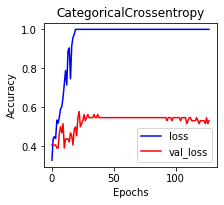

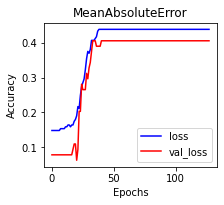

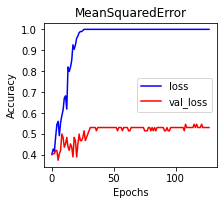

In [58]:
max_value_key_sets_for_losses = []
pandas_means = []
k = 1
for key_loss, each_loss in enumerate(used_losses):
  print(each_loss)

  max_value_for_each_loss = 0
  key_for_max_value = 0
  each_accumulate = 0
  each_accumulate_for_power = 0
  for row in range(6):
    epochs = len(some_histories[key_loss][row])
    print(some_histories[key_loss][row]["val_acc"][epochs-1])
    # calculate for each sum
    each_accumulate += some_histories[key_loss][row]["val_acc"][epochs-1]
    # calculate for each
    each_accumulate_for_power += some_histories[key_loss][row]["val_acc"][epochs-1] * some_histories[key_loss][row]["val_acc"][epochs-1]
    # caluculate for mean plot
    if row == 0:
      each_accumulate_all = some_histories[key_loss][row]
    else:
      each_accumulate_all = each_accumulate_all + some_histories[key_loss][row]


    if some_histories[key_loss][row]["val_acc"][epochs-1] > max_value_for_each_loss:
      max_value_for_each_loss = some_histories[key_loss][row]["val_acc"][epochs-1]
      key_for_max_value = row
      
    else:
      pass

  each_last_sum = each_accumulate
  each_last_mean = each_last_sum / 6
  each_last_power_mean = each_accumulate_for_power / 6
  each_standard_deviation = math.sqrt(each_last_power_mean - (each_last_mean * each_last_mean))
  print("For", each_loss)
  print("when the key is", key_for_max_value)
  print("the max value is", max_value_for_each_loss)
  print("the sum value is", each_last_sum)
  print("the mean value is", each_last_mean)
  print("the standard deviation is", each_standard_deviation, "\n")
  each_mean_pandas = each_accumulate_all / 6
  pandas_means.append(each_mean_pandas)

  fig = plt.figure(figsize=(WIDTH, HEIGHT))
  ACC_plt = fig.add_subplot(6, 2, k)
  ACC_plt.set_position([0.3*2*rate, 0.2*rate, 0.3, 0.2])
  ACC_plt.set_title(each_loss)
  ACC_plt.set_xlabel('Epochs')
  ACC_plt.set_ylabel('Accuracy')
  # plot
  acc = some_histories[key_loss][key_for_max_value]["acc"] 
  val_acc = some_histories[key_loss][key_for_max_value]["val_acc"]
  ACC_plt.plot(acc, label='loss', color='blue') # plot acc
  ACC_plt.plot(val_acc, label='val_loss', color='red') # plot val_loss
  ACC_plt.legend(loc='best')
  k += 1



  max_value_key_set = [max_value_for_each_loss, key_for_max_value]
  max_value_key_sets_for_losses.append(max_value_key_set)
    

In [59]:
for key_loss, each_loss in enumerate(used_losses):
  print(each_loss)
  print("when the No.", max_value_key_sets_for_losses[key_loss][1])
  print("the max value", max_value_key_sets_for_losses[key_loss][0])

CategoricalCrossentropy
when the No. 0
the max value 0.53125
MeanAbsoluteError
when the No. 0
the max value 0.40625
MeanSquaredError
when the No. 0
the max value 0.53125


# 精度比較

## 代表値：最大値を比較

CategoricalCrossentropy
MeanAbsoluteError
MeanSquaredError


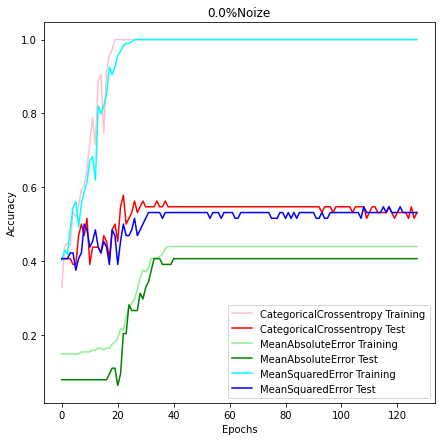

In [25]:
test_color_set = ['red', 'green', 'blue']
train_color_set = ['pink', 'lightgreen', 'aqua']
noize_for_title = float(re.sub(r"noize=", "", noize_rate)) * 100
noize_for_title = str(noize_for_title) + "%Noize"


fig = plt.figure(figsize=(7, 7))
ACC_plt = fig.add_subplot(111)
ACC_plt.set_title(noize_for_title)
ACC_plt.set_xlabel('Epochs')
ACC_plt.set_ylabel('Accuracy')


for key_loss, each_loss in enumerate(used_losses):
  print(each_loss)
  acc = some_histories[key_loss][max_value_key_sets_for_losses[key_loss][1]]["acc"]
  ACC_plt.plot(acc, label=each_loss+" Training", color=train_color_set[key_loss])
  val_acc = some_histories[key_loss][max_value_key_sets_for_losses[key_loss][1]]["val_acc"]
  ACC_plt.plot(val_acc, label=each_loss+" Test", color=test_color_set[key_loss])

ACC_plt.legend(loc='lower right')
filename = noize_for_title + "Accuracy_Plot" + ".png"
save_path = path.join(desk, filename)
fig.savefig(save_path, bbox_inches='tight')

In [14]:
!pip install pytab

In [15]:

used_losses.append("Average")

accumulate = 0
for i, each in enumerate(max_value_key_sets_for_losses):
  value = each[0]
  accumulate += value
average = accumulate / (i+1)


In [16]:
import pytab as pt


if __name__ == '__main__':
    data = {
        'Loss': used_losses,
        'Accuracy': [
                     '{:.4f}'.format(max_value_key_sets_for_losses[0][0]),
                     '{:.4f}'.format(max_value_key_sets_for_losses[1][0]),
                     '{:.4f}'.format(max_value_key_sets_for_losses[2][0]),
                     '{:.4f}'.format(average)] }

    pt.table(
        data=data,
        th_type='light',
        th_loc='center',
        figsize=(5, 5)

        # table_type='striped'
    )
    filename = noize_for_title + "Accuracy_Table" + ".png"
    save_path = path.join(desk, filename)
    pt.save(save_path)   

ValueError: ignored

# 代表値：平均値を比較

CategoricalCrossentropy
MeanAbsoluteError
MeanSquaredError
Average


IndexError: ignored

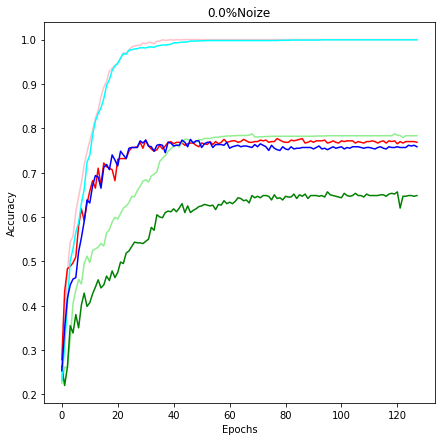

In [ ]:
test_color_set = ['red', 'green', 'blue']
train_color_set = ['pink', 'lightgreen', 'aqua']
noize_for_title = float(re.sub(r"noize=", "", noize_rate)) * 100
noize_for_title = str(noize_for_title) + "%Noize"


fig = plt.figure(figsize=(7, 7))
ACC_plt = fig.add_subplot(111)
ACC_plt.set_title(noize_for_title)
ACC_plt.set_xlabel('Epochs')
ACC_plt.set_ylabel('Accuracy')

for key_loss, each_loss in enumerate(used_losses):
  print(each_loss)
  

  acc = pandas_means[key_loss]['acc']
  ACC_plt.plot(acc, label=each_loss+" Training", color=train_color_set[key_loss])
  val_acc = pandas_means[key_loss]['val_acc']
  ACC_plt.plot(val_acc, label=each_loss+" Test", color=test_color_set[key_loss])

ACC_plt.legend(loc='lower right')
filename = noize_for_title + "Accuracy" 
filename += "-(mean)" 
filename += ".png"

save_path = path.join(desk, filename)
fig.savefig(save_path, bbox_inches='tight')

# 代表値：気になる値を比較

In [27]:
favorite = [3, 0, 0]

CategoricalCrossentropy
MeanAbsoluteError
MeanSquaredError


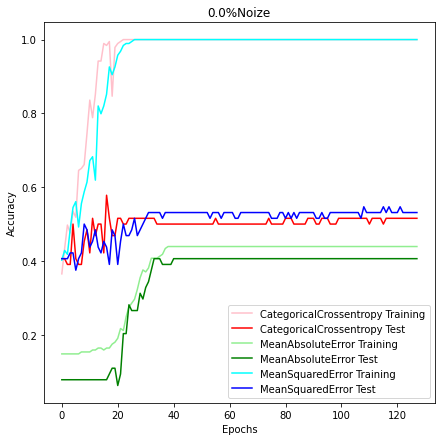

In [61]:
test_color_set = ['red', 'green', 'blue']
train_color_set = ['pink', 'lightgreen', 'aqua']
noize_for_title = float(re.sub(r"noize=", "", noize_rate)) * 100
noize_for_title = str(noize_for_title) + "%Noize"


fig = plt.figure(figsize=(7, 7))
ACC_plt = fig.add_subplot(111)
ACC_plt.set_title(noize_for_title)
ACC_plt.set_xlabel('Epochs')
ACC_plt.set_ylabel('Accuracy')


for key_loss, each_loss in enumerate(used_losses):
  print(each_loss)
  acc = some_histories[key_loss][favorite[key_loss]]["acc"]
  ACC_plt.plot(acc, label=each_loss+" Training", color=train_color_set[key_loss])
  val_acc = some_histories[key_loss][favorite[key_loss]]["val_acc"]
  ACC_plt.plot(val_acc, label=each_loss+" Test", color=test_color_set[key_loss])

ACC_plt.legend(loc='lower right')
filename = noize_for_title + "Accuracy_Plot_favorite" + ".png"
save_path = path.join(desk, filename)
fig.savefig(save_path, bbox_inches='tight')

In [ ]:
!pip install pytab

In [52]:
accumulate = 0
for key_loss, each_loss in enumerate(used_losses):
  value = some_histories[key_loss][favorite[key_loss]]["val_acc"][epochs-1]
  accumulate += value

average = accumulate / (key_loss+1)



1.453125


In [71]:
import pytab as pt


if __name__ == '__main__':
    used_losses.append("Average")
    data = {
        'Loss': used_losses,
        'Accuracy': [
                     '{:.4f}'.format(some_histories[0][3]["val_acc"][epochs-1]),
                     '{:.4f}'.format(some_histories[1][0]["val_acc"][epochs-1]),
                     '{:.4f}'.format(some_histories[2][0]["val_acc"][epochs-1]),
                     '{:.4f}'.format(average)] }

    pt.table(
        data=data,
        th_type='light',
        th_loc='center',
        figsize=(5, 5)

        # table_type='striped'
    )
    filename = noize_for_title + "Accuracy_Table_favorite" + ".png"
    save_path = path.join(desk, filename)
    pt.save(save_path)   